### Step 4: .

__Step goal__: Perform decomposition and clustering on socio-demographic variables.

__Step overview__:
1. Load the data;
2. Decomposition;
3. Clustering.

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA 
# import nimfa
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
from tqdm import tqdm
import os
import pickle

plt.style.use('seaborn-whitegrid')

#### 1. Load the data

Note that we didn't apply scaling (dividing all variables of a certain category by the total).

In [13]:
city = 'san_francisco'
country = 'united_states'
extended_variables = True

# short list of variables
if extended_variables == False:
    data = pd.read_csv(f'../../variables/{city}_short.csv')

    if country == 'canada':
        variable_names = pd.read_csv(f'../../variables/{city}_short_variable_names.csv')['variable_name'].tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.json')
            
    if country == 'united_states':
        variable_names = pd.read_csv(f'../../variables/{city}_short.csv').columns.tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.geojson')
# long list of variables
else: 
    data = pd.read_csv(f'../../variables/{city}.csv')

    if country == 'canada':
        variable_names = pd.read_csv(f'../../variables/{city}_variable_names.csv')['variable_name'].tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.json')
        
    if country == 'united_states':
        variable_names = pd.read_csv(f'../../variables/{city}.csv').columns.tolist()
        geometry = gpd.read_file(f'../../data/processed/geometry/{country}/{city}.geojson')

gdf = pd.merge(data, geometry, left_index=True, right_index=True)
print(f'Sample size : {data.shape[0]}')  
print(f'Number of variables : {data.shape[1]}')

Sample size : 579
Number of variables : 25


#### 2. Decomposition

##### PCA

One should be careful applying PCA on small sample, but with a large number of variables. The more similar the objects, the more of them is needed to get PCA to work. Another option is to use less variables. The rule of thumb is 5 to 1 ratio (5 objects on 1 variable).

In [4]:
# Note that type of scaling significantly affects the results of the algorithm
# Scale the variables between 0 and 1
scaler = MinMaxScaler()
# scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

In [27]:
X_scaled.shape[0] / X_scaled.shape[1]

22.636363636363637

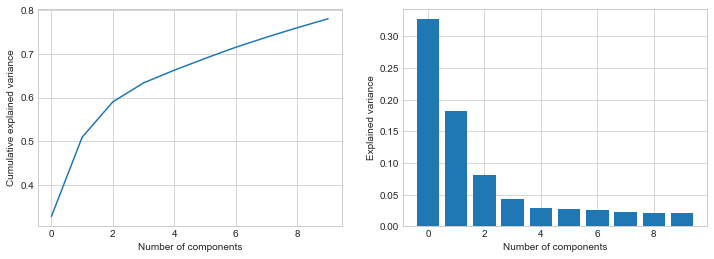

In [28]:
# Explore PCA
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
random_state = 1235
pca = PCA(n_components=10, random_state=random_state).fit(X_scaled)
ax[0].plot(np.cumsum(pca.explained_variance_ratio_))
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Cumulative explained variance')

ax[1].bar(range(pca.n_components_), pca.explained_variance_ratio_)
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Explained variance');

In case of PCA, the number of components equal to __6__ seems to be good-enough option.

In [29]:
n_components = 6
pca = PCA(n_components=n_components, random_state=random_state)
X_new = pca.fit_transform(X_scaled)
components = pca.components_

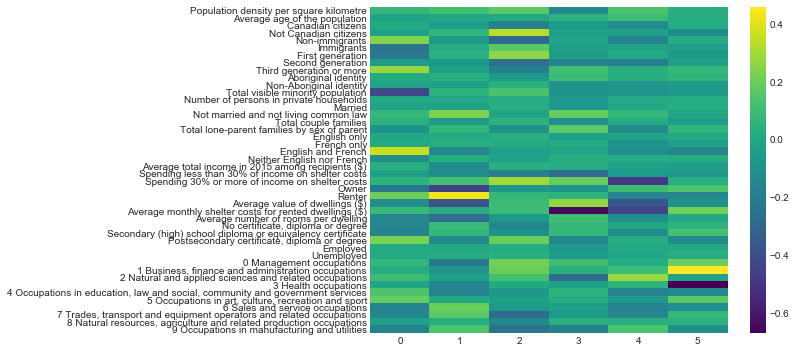

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(components.T, yticklabels=variable_names, cmap='viridis');

##### NMF

In [31]:
metrics = {}
for rank in range(2, 10):
    nmf = nimfa.Nmf(X_scaled, rank=rank)
    nmf_fit = nmf()
    metrics[rank] = {'Residual Sum of Squares' : nmf_fit.fit.rss(), 
                     'Explained variance' : nmf_fit.fit.evar(), 
                     'Loss function value' : nmf_fit.distance(metric='kl'), 
                     'Sparseness of matrix' : nmf_fit.fit.sparseness()}

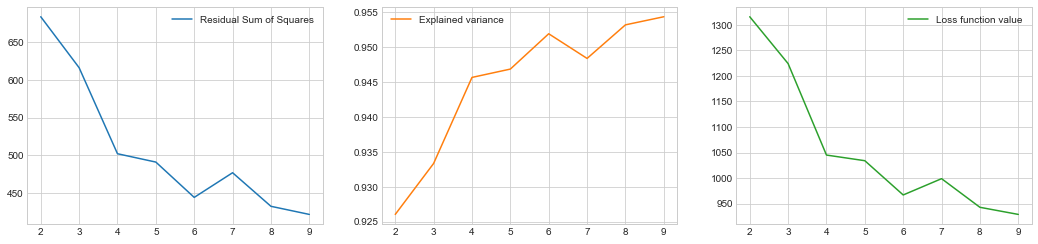

In [32]:
pd.DataFrame(metrics).iloc[:-1,:].T.plot(subplots=True, layout=(1, 3), figsize=(18,4), rot=0, sharex=False);

It seems that NMF with a rank of __6__ has the best-satisfactory metrics. Let's try to explain resulting decomposition with a heatmap.

In [33]:
rank = 6
nmf = nimfa.Nmf(X_scaled, rank=rank)
nmf_fit = nmf()

In [34]:
basis = nmf_fit.basis()
coef = nmf_fit.coef()

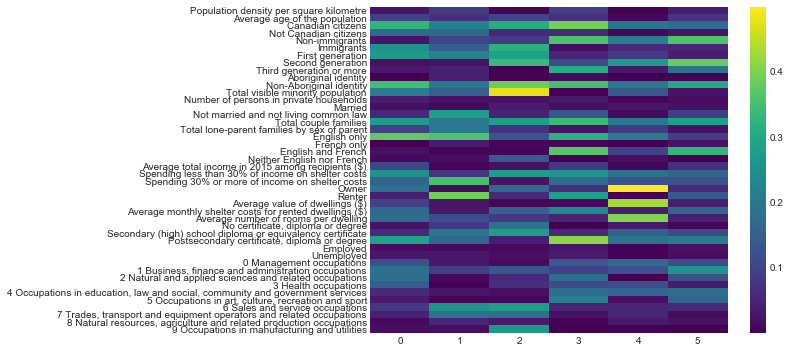

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(coef.T, yticklabels=variable_names, annot=False, cmap='viridis');

#### 3. Clustering

In [36]:
# Raw data
X = data

Raw data has outliers. What to do? It's a complicated question, since we don't want to exclude certain city areas from the analysis. But the presence of the outliers can significantly affect clustering.

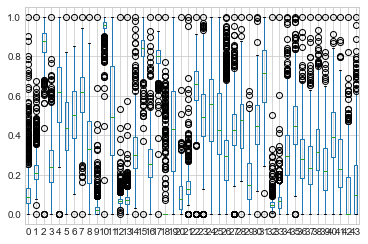

In [37]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data)
pd.DataFrame(X_scaled).boxplot();

##### Outlier removeal

###### Z-score

In statistics, the standard score __(Z-score)__ is the number of standard deviations by which the value of a raw score (i.e., an observed value or data point) is above or below the mean value of what is being observed or measured (Wikipedia contributors, 2020, March 4). The formula for Z-score is as follows:

\begin{equation*}
z = \frac{x - μ}{σ}
\end{equation*}

Initial number of polygons : 996
Polygons left after we excluded outliers : 890
106 polygons removed


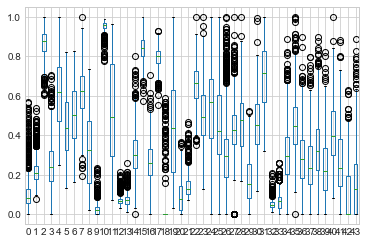

In [38]:
# Calculate Z-score
# It doesn't matter whether Z-score will be calculated on raw data or on the data scaled with MinMaxScaler, 
# but StandardScaler will change the outcome
z = np.abs(zscore(data.values, axis=0))

# Define a threshold?
threshold = 4

# np.where(z < threshold) # to see which elements are outliers
df = pd.DataFrame(X_scaled)[(z < threshold).all(axis=1)]
print(f'Initial number of polygons : {data.shape[0]}')
print(f'Polygons left after we excluded outliers : {df.shape[0]}')
n_outliers = data.shape[0] - df.shape[0]
print(f'{n_outliers} polygons removed')
df.boxplot();
# df.to_csv('../data/interim/data_wo_outliers.csv', index=False)

In [39]:
df = pd.merge(df, geometry, left_index=True, right_index=True)

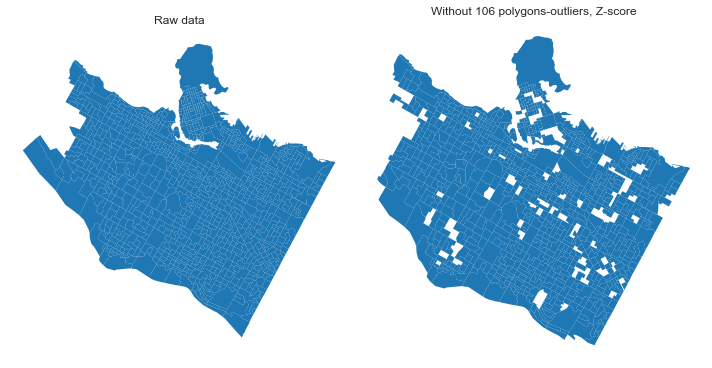

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
gpd.GeoDataFrame(gdf).plot(ax=ax[0])
ax[0].set_title('Raw data')
ax[0].axis('off')
gpd.GeoDataFrame(df).plot(ax=ax[1])
ax[1].set_title(f'Without {n_outliers} polygons-outliers, Z-score')
ax[1].axis('off')
plt.tight_layout();

In [47]:
# Save preprocessed variables for clustering in R
df.drop(['geometry', 'id'], axis=1).fillna(0).to_csv('../data/interim/data_zscored.csv', index=False)

###### Interquartile range

As an alternative to Z-score we can use the __Interquartile range__. In descriptive statistics, the interquartile range (IQR), also called the midspread, middle 50%, or H‑spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles.

IQR = Q3 − Q1. Outliers are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR.

In [48]:
df = pd.DataFrame(X_scaled)
q1 = df.quantile(0.1)
q3 = df.quantile(0.9)
iqr = q3 - q1
# iqr

Initial number of polygons : 996
Polygons left after we excluded outliers : 832
164 polygons removed


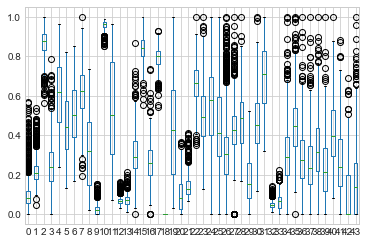

In [49]:
df = df[~((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).any(axis=1)]
print(f'Initial number of polygons : {X_scaled.shape[0]}')
print(f'Polygons left after we excluded outliers : {df.shape[0]}')
n_outliers = data.shape[0] - df.shape[0]
print(f'{n_outliers} polygons removed')
df.boxplot();

In [50]:
df = pd.merge(df, geometry, left_index=True, right_index=True)

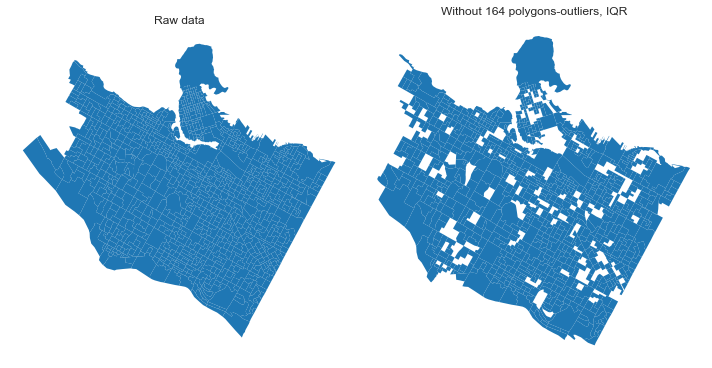

In [51]:
fig, ax = plt.subplots(ncols=2, figsize=(10,8))
gpd.GeoDataFrame(gdf).plot(ax=ax[0])
ax[0].set_title('Raw data')
ax[0].axis('off')
gpd.GeoDataFrame(df).plot(ax=ax[1])
ax[1].set_title(f'Without {n_outliers} polygons-outliers, IQR')
ax[1].axis('off')
plt.tight_layout();

In [52]:
# Save preprocessed variables for clustering in R
df.drop(['geometry', 'id'], axis=1).fillna(0).to_csv('../data/interim/data_iqr.csv', index=False)

### Winsorizing 

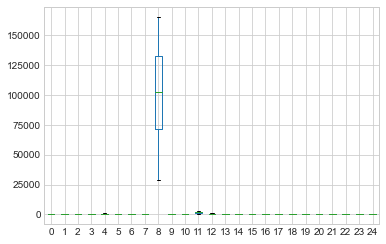

In [14]:
from scipy.stats import mstats
data_winsorized = mstats.winsorize(data, inplace=True, axis=0, limits=[0.1, 0.1])
pd.DataFrame(data_winsorized).boxplot();

In [15]:
if extended_variables == False:
    pd.DataFrame(data_winsorized).fillna(0).to_csv(f'../../data/interim/preprocessed/{city}_short_winsorized.csv', index=False)
else:
    pd.DataFrame(data_winsorized).fillna(0).to_csv(f'../../data/interim/preprocessed/{city}_winsorized.csv', index=False)

##### K-means

__Partitioning__

K-means limitations (assumptions?):
* algorithm is sensitive to outliers;
* it reponds poorly to elongated or manifolds with irregular shape, instead it seeks for speherical clusters (Igual & Seguí, 2017);
* algorithm may not converge to the global minimum. To deal with the problem we need first pefrom the algorithm with different centroid initialziations and second use various random seeds (radom seed is also a hyperparameter).

In [106]:
X_scaled = StandardScaler().fit_transform(data_winsorized)

In [107]:
k_min = 2
k_max = 20

models = {}
labels = {}

init = 'k-means++'
n_init = 100
random_state = 1235

print(f'Perform K-means clustering with {n_init} {init} centorid initalizations.')

Perform K-means clustering with 100 k-means++ centorid initalizations.


In [108]:
for k in tqdm(range(k_min, k_max + 1)):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, random_state=random_state)
    models[k] = kmeans.fit(X_scaled)
    labels[k] = models[k].labels_

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:25<00:00,  1.32s/it]


Silhouette score is defined as:

\begin{equation*}
s = \frac{b - a}{max(a,b)}
\end{equation*}

where:
* a - the mean distance between a sample and all other points in the same class, 
* b - the mean distance between a sample and all other points in the _next nearest_ cluster.

What is important is that all metrics have their own specifics: advantages, disadvantages, and use-cases. So, one cannot rely blindly on a single metric when selecting the number of clusters.

In [109]:
# Silhouette, Calinski-Harabasz, Davies-Bouldin
clustering_metrics = {}
ss = {}
ch = {}
db = {}

delimiter = 1

for key, value in models.items():
    ss[key] = silhouette_score(X_scaled, labels[key], random_state=random_state)
    ch[key] = round(calinski_harabasz_score(X_scaled, labels[key]) / delimiter, 3)
    db[key] = round(davies_bouldin_score(X_scaled, labels[key]), 3)
    
clustering_metrics["Silhouette score"] = ss
clustering_metrics["Calinski-Harabasz"] = ch
clustering_metrics["Davies-Bouldin"] = db

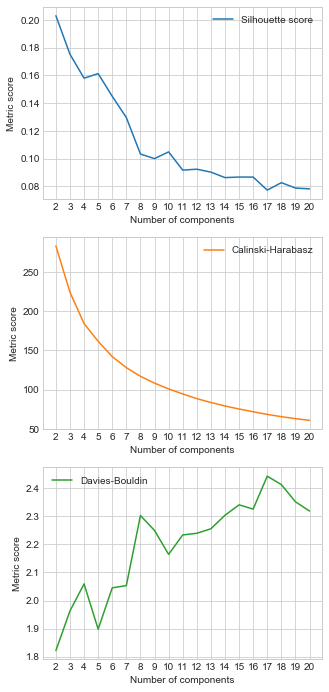

In [110]:
ax = pd.DataFrame(clustering_metrics).plot(subplots=True, layout=(3, 1), figsize=(5, 12), rot=0, xticks=np.arange(k_min, k_max + 1), sharex=False);
for i in range(0, 3):
    ax[i, 0].set_xlabel('Number of components')
    ax[i, 0].set_ylabel('Metric score')

It seems that clustering with number of clusters = 2 has the best metrics. However, for our study such number of clusters is too less. We know the number of _urban profiles_ is higher than that. To better understand what can be a better option, let's select a range of clusters and explore them with a map. 

In [111]:
# Save the variables
directory = f"../models/british_columbia/{city}/kmeans/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

k_min = 2
k_max = 5
for k in tqdm(range(k_min, k_max + 1)):
    filename = directory + f'{k}_clusters.sav'
    pickle.dump(models[k], open(filename, 'wb'))
    np.save(directory + f"{k}_cluster_labels.npy", labels[k])

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 802.16it/s]


In [112]:
# Save the data used for clustering as well
method = 'kmeans'
pd.DataFrame(data_winsorized).to_csv(f'../models/british_columbia/{city}/{method}/data.csv', index=False)

##### Hierarchical Agglomerative Clustering (HAC)

__Similarity = Closeness__

In a nutshell, HAC works as follows: it starts with assigning a unique cluster to all of the objects (aglomearte from bottom-up), then it selects the nearest pair of distinct clusters, merges them and decreases the number of clusters by one. This procedure is repeated until the number of clusters left will be equal to 1 (Everitt & Hothorn, 2011).

To measure whether or not two individual objects are near, we need to calculate a _distance matrix_. The distance between the two objects can be measured differently. The most "common" metric is __Euclidean__ distance. After the distances between individuals were calculated, we need  to calculate the second type of distance: between an indiviudal object and a group = a cluster called __inter-group__ measure. Again, there are different types of this measure: _single, complete, average_ and _ward_ linkages. __The linkage function defines the outcome of the clustering very much.__ Average linkage often lead to unequal cluster sizes, whereas Ward produces balanced ones. 

Importantly, measuring the distance on the raw data can be nonsense, if the variables are on very different scales. To overcome this issue we need to "standardize" the data. However, standardization has some drawbacks?

In [119]:
X_scaled = StandardScaler().fit_transform(data_winsorized)

Run import packages cell once again to continue.

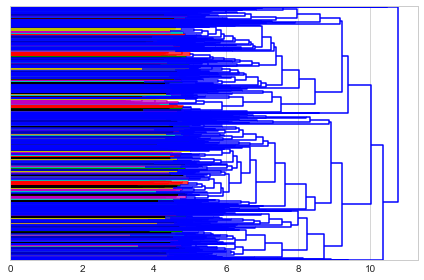

In [120]:
# Scipy implementation
dist = pdist(X_scaled, metric='euclidean')
linkage_matrix = linkage(dist, method='average')
dendrogram(linkage_matrix, orientation='right', color_threshold=5, no_labels=True)
plt.tight_layout()

In [121]:
# Sklearn implementation
k_min = 2
k_max = 20

models = {}
labels = {}

affinity = 'euclidean'
linkage = 'average'
random_state = 1235

print(f'Perform agglomerative clustering with {affinity.capitalize()} distance and {linkage} linkage.')

for k in range(k_min, k_max + 1):
    agglomerative_clustering = AgglomerativeClustering(n_clusters=k, affinity=affinity, linkage=linkage)
    models[k] = agglomerative_clustering.fit(X_scaled)
    labels[k] = models[k].labels_

Perform agglomerative clustering with Euclidean distance and average linkage.


In [122]:
# Silhouette, Calinski-Harabasz, Davies-Bouldin
clustering_metrics = {}
ss = {}
ch = {}
db = {}

delimiter = 1

for key, value in models.items():
    ss[key] = silhouette_score(X_scaled, labels[key], random_state=random_state)
    ch[key] = round(calinski_harabasz_score(X_scaled, labels[key]) / delimiter, 3)
    db[key] = round(davies_bouldin_score(X_scaled, labels[key]), 3)
    
clustering_metrics["Silhouette score"] = ss
clustering_metrics["Calinski-Harabasz"] = ch
clustering_metrics["Davies-Bouldin"] = db

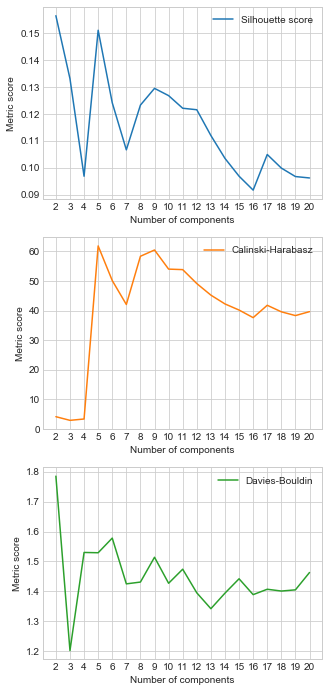

In [123]:
ax = pd.DataFrame(clustering_metrics).plot(subplots=True, layout=(3, 1), figsize=(5, 12), rot=0, xticks=np.arange(k_min, k_max + 1), sharex=False);
for i in range(0, 3):
    ax[i, 0].set_xlabel('Number of components')
    ax[i, 0].set_ylabel('Metric score')

In [124]:
# Save the variables
directory = f"../models/british_columbia/{city}/hac/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)

k_min = 2
k_max = 5
for k in tqdm(range(k_min, k_max + 1)):
    filename = directory + f'{k}_clusters.sav'
    pickle.dump(models[k], open(filename, 'wb'))
    np.save(directory + f"{k}_cluster_labels.npy", labels[k])

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 1003.06it/s]


In [125]:
# Save the data used for clustering as well
method = 'hac'
pd.DataFrame(data_winsorized).to_csv(f'../models/british_columbia/{city}/{method}/data.csv', index=False)

##### K-medoids

K-medoids is more robust to outliers than K-Means. Python implementations of the algorithm are a bit confusing. Results are in the pam.R script.

In [127]:
directory = f"../models/british_columbia/{city}/pam/"
if not os.path.exists(directory):
    print(f'Succefully created new directory {directory}')
    os.makedirs(directory)
data.to_csv(directory + 'data.csv', index=False)

##### Consensus clustering

It seems that there is no stable implementation of Consensus clusteing in Python on 09-05-2020. Results are in consensus_clustering.R script.

# References

1. Igual, L., & Seguí, S. (2017). Introduction to Data Science. Springer International Publishing. https://doi.org/10.1007/978-3-319-50017-1
2. Everitt, B., & Hothorn, T. (2011). An Introduction to Applied Multivariate Analysis with R. Springer New York. https://doi.org/10.1007/978-1-4419-9650-3
3. Wikipedia contributors. (2020, March 4). Standard score. In Wikipedia, The Free Encyclopedia. Retrieved 10:22, May 9, 2020, from https://en.wikipedia.org/w/index.php?title=Standard_score&oldid=943827654
4. Wikipedia contributors. (2020, April 27). Interquartile range. In Wikipedia, The Free Encyclopedia. Retrieved 11:12, May 9, 2020, from https://en.wikipedia.org/w/index.php?title=Interquartile_range&oldid=953495961